# Flax Imagenet Example

<a href="https://colab.research.google.com/github/google/flax/blob/main/examples/imagenet/imagenet.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration notebook for
https://github.com/google/flax/tree/main/examples/imagenet


The **Flax Notebook Workflow**:

1. Run the entire notebook end-to-end and check out the outputs.
   - This will open Python files in the right-hand editor!
   - You'll be able to interactively explore metrics in TensorBoard.
2. Change `config` and train for different hyperparameters. Check out the
   updated TensorBoard plots.
3. Update the code in `train.py`. Thanks to `%autoreload`, any changes you
   make in the file will automatically appear in the notebook. Some ideas to
   get you started:
   - Change the model.
   - Log some per-batch metrics during training.
   - Add new hyperparameters to `configs/default.py` and use them in
     `train.py`.
4. At any time, feel free to paste code from `train.py` into the notebook
   and modify it directly there!

## Setup

In [28]:
# Tested with a T4 GPU.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d1652fa8-88b9-3d02-7a65-e7ebabeb0372)


In [29]:
# Install ml-collections & latest Flax version from Github.
!pip install -q clu ml-collections git+https://github.com/google/flax

  Preparing metadata (setup.py) ... done


In [30]:
example_directory = 'examples/imagenet'
editor_relpaths = ('configs/default.py', 'input_pipeline.py', 'models.py', 'train.py')

repo, branch = 'https://github.com/google/flax', 'main'

In [31]:
# (If you run this code in Jupyter[lab], then you're already in the
#  example directory and nothing needs to be done.)

#@markdown **Fetch newest Flax, copy example code**
#@markdown
#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted and any changes are lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will be *persisted*, and even if you re-run the
#@markdown Colab later on, the files will still be the same (you can of course
#@markdown remove directories inside your Drive's `flax/` root if you want to
#@markdown manually revert these files).

if 'google.colab' in str(get_ipython()):
  import os
  os.chdir('/content')
  # Download Flax repo from Github.
  if not os.path.isdir('flaxrepo'):
    !git clone --depth=1 -b $branch $repo flaxrepo
  # Copy example files & change directory.
  mount_gdrive = 'no' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive')
    example_root_path = f'/content/gdrive/My Drive/flax/{example_directory}'
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    example_root_path = f'/content/{example_directory}'
    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))
  if not os.path.isdir(example_root_path):
    os.makedirs(example_root_path)
    !cp -r flaxrepo/$example_directory/* "$example_root_path"
  os.chdir(example_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{example_root_path}/{relpath}').read()
    open(f'{example_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{example_root_path}/{relpath}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Note : In Colab, above cell changed the working directory.
!pwd

## Imports / Helpers

In [33]:
# It's possible to run this Colab with TPUs:
# 1. change runtime type to TPU
# 2. install compatible flax version: `!pip install flax==0.6.4 jax==0.3.25 jaxlib==0.3.25`
# 3. uncomment lines below

# import flax, jax, jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

import jax
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [34]:
import json
from absl import logging
import flax
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

logging.set_verbosity(logging.INFO)

In [35]:
# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  img *= tf.constant(input_pipeline.STDDEV_RGB, shape=[1, 1, 3], dtype=img.dtype)
  img += tf.constant(input_pipeline.MEAN_RGB, shape=[1, 1, 3], dtype=img.dtype)
  img = np.clip(img.numpy().astype(int), 0, 255)
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [36]:
# Local imports from current directory - auto reload.
# Any changes you make to train.py will appear automatically.
%load_ext autoreload
%autoreload 2
import input_pipeline
import models
import train
from configs import default as config_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [37]:
# We load "imagenette" that has similar pictures to "imagenet2012" but can be
# downloaded automatically and is much smaller.
dataset_builder = tfds.builder('imagenette')
dataset_builder.download_and_prepare()
ds = dataset_builder.as_dataset('train')
dataset_builder.info

INFO:absl:No config specified, defaulting to config: imagenette/full-size-v2
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Reusing dataset imagenette (/root/tensorflow_datasets/imagenette/full-size-v2/1.0.0)
INFO:absl:Constructing tf.data.Dataset imagenette for split train, from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0


tfds.core.DatasetInfo(
    name='imagenette',
    full_name='imagenette/full-size-v2/1.0.0',
    description="""
    Imagenette is a subset of 10 easily classified classes from the Imagenet
    dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
    behind putting together a small version of the Imagenet dataset was mainly
    because running new ideas/algorithms/experiments on the whole Imagenet take a
    lot of time.
    
    This version of the dataset allows researchers/practitioners to quickly try out
    ideas and share with others. The dataset comes in three variants:
    
    *   Full size
    *   320 px
    *   160 px
    
    Note: The v2 config correspond to the new 70/30 train/valid split (released in
    Dec 6 2019).
    """,
    config_description="""
    full-size variant.
    """,
    homepage='https://github.com/fastai/imagenette',
    data_path='/root/tensorflow_datasets/imagenette/full-size-v2/1.0.0',
    file_format=tfrecord,
    download_

In [38]:
# Utilities to help with Imagenette labels.

![ ! -f mapping_imagenet.json ] && wget --no-check-certificate https://raw.githubusercontent.com/ozendelait/wordnet-to-json/master/mapping_imagenet.json

with open('mapping_imagenet.json') as f:
  mapping_imagenet = json.load(f)
# Mapping imagenette label name to imagenet label index.
imagenette_labels = {
    d['v3p0']: d['label']
    for d in mapping_imagenet
}
# Mapping imagenette label name to human-readable label.
imagenette_idx = {
    d['v3p0']: idx
    for idx, d in enumerate(mapping_imagenet)
}

def imagenette_label(idx):
  """Returns a short human-readable string for provided imagenette index."""
  net = dataset_builder.info.features['label'].int2str(idx)
  return imagenette_labels[net].split(',')[0]

def imagenette_imagenet2012(idx):
  """Returns the imagenet2012 index for provided imagenette index."""
  net = dataset_builder.info.features['label'].int2str(idx)
  return imagenette_idx[net]

def imagenet2012_label(idx):
  """Returns a short human-readable string for provided imagenet2012 index."""
  return mapping_imagenet[idx]['label'].split(',')[0]

In [39]:
train_ds = input_pipeline.create_split(
    dataset_builder, 128, train=True,
)
eval_ds = input_pipeline.create_split(
    dataset_builder, 128, train=False,
)

INFO:absl:Constructing tf.data.Dataset imagenette for split train[0:9469], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation[0:3925], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0


In [40]:
train_batch = next(iter(train_ds))
{k: (v.shape, v.dtype) for k, v in train_batch.items()}

{'image': (TensorShape([128, 224, 224, 3]), tf.float32),
 'label': (TensorShape([128]), tf.int64)}

## Training from scratch

In [ ]:
# Get a live update during training - use the "refresh" button!
# (In Jupyter[lab] start "tensorboard" in the local directory instead.)
if 'google.colab' in str(get_ipython()):
  %load_ext tensorboard
  %tensorboard --logdir=.

In [42]:
config = config_lib.get_config()
config.dataset = 'imagenette'
config.model = 'ResNet18'
config.half_precision = True
# Reduce batch size, shuffle buffer and prefetch to avoid Colab runtime OOM.
config.batch_size = 32
config.shuffle_buffer_size = 128
config.prefetch = 1
# Reduce epochs so this Colab doesn't take forever.
config.num_epochs = 5.0
config.warmup_epochs = 0.5
config

batch_size: 32
cache: false
dataset: imagenette
half_precision: true
learning_rate: 0.1
log_every_steps: 100
model: ResNet18
momentum: 0.9
num_epochs: 5.0
num_train_steps: -1
prefetch: 1
shuffle_buffer_size: 128
steps_per_eval: -1
warmup_epochs: 0.5

In [43]:
# Regenerate datasets with updated batch_size.
train_ds = input_pipeline.create_split(
    dataset_builder, config.batch_size, train=True,
)
eval_ds = input_pipeline.create_split(
    dataset_builder, config.batch_size, train=False,
)

INFO:absl:Constructing tf.data.Dataset imagenette for split train[0:9469], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation[0:3925], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0


In [44]:
# Takes ~1.5 min / epoch.
for lr in  (0.03, 0.1, 0.3):
  config.learning_rate = lr
  name = f'{config.model}_lr={config.learning_rate}'
  print(f'\n\n{name}')
  state = train.train_and_evaluate(config, workdir=f'./models/{name}')

INFO:absl:No config specified, defaulting to config: imagenette/full-size-v2
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split train[0:9469], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0




ResNet18_lr=0.03


INFO:absl:Constructing tf.data.Dataset imagenette for split validation[0:3925], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Restoring legacy Flax checkpoint from models/ResNet18_lr=0.03/checkpoint_1475
INFO:absl:Initial compilation, this might take some minutes...
INFO:absl:No config specified, defaulting to config: imagenette/full-size-v2
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split train[0:9469], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0




ResNet18_lr=0.1


INFO:absl:Constructing tf.data.Dataset imagenette for split validation[0:3925], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Restoring legacy Flax checkpoint from models/ResNet18_lr=0.1/checkpoint_1475
INFO:absl:Initial compilation, this might take some minutes...
INFO:absl:No config specified, defaulting to config: imagenette/full-size-v2
INFO:absl:Load dataset info from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split train[0:9469], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0




ResNet18_lr=0.3


INFO:absl:Constructing tf.data.Dataset imagenette for split validation[0:3925], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Restoring legacy Flax checkpoint from models/ResNet18_lr=0.3/checkpoint_1475
INFO:absl:Initial compilation, this might take some minutes...


In [45]:
if 'google.colab' in str(get_ipython()):
  #@markdown You can upload the training results directly to https://tensorboard.dev
  #@markdown
  #@markdown Note that everybody with the link will be able to see the data.
  upload_data = 'no' #@param ['yes', 'no']
  if upload_data == 'yes':
    !tensorboard dev upload --one_shot --logdir ./models --name 'Flax examples/mnist'

## Load pre-trained model

In [46]:
# Load model checkpoint from cloud.
from flax.training import checkpoints

config_name = 'v100_x8'
pretrained_path = f'gs://flax_public/examples/imagenet/{config_name}'
latest_checkpoint = checkpoints.natural_sort(
    tf.io.gfile.glob(f'{pretrained_path}/checkpoint_*'))[0]
if not os.path.exists(os.path.basename(latest_checkpoint)):
  tf.io.gfile.copy(latest_checkpoint, os.path.basename(latest_checkpoint))
!ls -lh checkpoint_*

-rw-r--r-- 1 root root 196M Apr  3 13:38 checkpoint_250200


In [47]:
# Load config that was used to train checkpoint.
import importlib
config = importlib.import_module(f'configs.{config_name}').get_config()

In [48]:
# Load models & state (takes ~1 min to load the model).
model_cls = getattr(models, config.model)
model = train.create_model(
    model_cls=model_cls, half_precision=config.half_precision)
base_learning_rate = config.learning_rate * config.batch_size / 256.
steps_per_epoch = (
    dataset_builder.info.splits['train'].num_examples // config.batch_size
)
learning_rate_fn = train.create_learning_rate_fn(
    config, base_learning_rate, steps_per_epoch)
state = train.create_train_state(
    jax.random.key(0), config, model, image_size=input_pipeline.IMAGE_SIZE,
    learning_rate_fn=learning_rate_fn)
state = train.restore_checkpoint(state, './')

INFO:absl:Restoring legacy Flax checkpoint from ./checkpoint_250200


## Inference

In [49]:
# Load batch from imagenette eval set.
batch = next(iter(eval_ds))
{k: v.shape for k, v in batch.items()}

{'image': TensorShape([32, 224, 224, 3]), 'label': TensorShape([32])}

In [50]:
# Evaluate using model trained on imagenet.
logits = model.apply({'params': state.params, 'batch_stats': state.batch_stats}, batch['image'][:128], train=False)

In [51]:
# Find classification mistakes.
preds_labels = list(zip(logits.argmax(axis=-1), map(imagenette_imagenet2012, batch['label'])))
error_idxs = [idx for idx, (pred, label) in enumerate(preds_labels) if pred != label]
error_idxs

[16, 24]

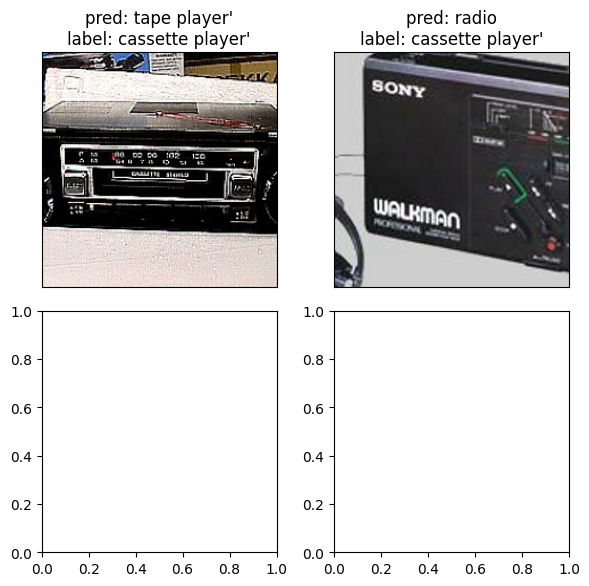

In [52]:
# The mistakes look all quite reasonable.
show_img_grid(
    [batch['image'][idx] for idx in error_idxs[:9]],
    [f'pred: {imagenet2012_label(preds_labels[idx][0])}\n'
     f'label: {imagenet2012_label(preds_labels[idx][1])}'
    for idx in error_idxs[:9]],
)
plt.tight_layout()

In [53]:
# Define parallelized inference function in separate cell so the cached
# compilation can be used if below cell is executed multiple times.
@jax.pmap
def p_get_logits(images):
  return model.apply({'params': state.params, 'batch_stats': state.batch_stats},
                     images, train=False)

eval_iter = train.create_input_iter(dataset_builder, config.batch_size,
                                    input_pipeline.IMAGE_SIZE, tf.float32,
                                    train=False, cache=False, shuffle_buffer_size=None,
                                    prefetch=1)

INFO:absl:Constructing tf.data.Dataset imagenette for split validation[0:3925], from /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0


In [54]:
# Compute accuracy.
eval_steps = dataset_builder.info.splits['validation'].num_examples // config.batch_size
count = correct = 0
for step, batch in zip(range(eval_steps), eval_iter):
  labels = [imagenette_imagenet2012(label) for label in batch['label'].flatten()]
  logits = p_get_logits(batch['image'])
  logits = logits.reshape([-1, logits.shape[-1]])
  print(f'Step {step+1}/{eval_steps}...')
  count += len(labels)
  correct += (logits.argmax(axis=-1) == jnp.array(labels)).sum()

correct / count

Step 1/7...
Step 2/7...
Step 3/7...
Step 4/7...
Step 5/7...
Step 6/7...
Step 7/7...


Array(0.9118304, dtype=float32)